In [1]:
# %%
# Import necessary libraries for data handling, model utilization, and visualization
import numpy as np
import pandas as pd
import yfinance as yf  # For collecting financial data
import matplotlib.pyplot as plt
from typing import List, Dict, Optional, Tuple
from datetime import datetime, timedelta
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from scipy.optimize import minimize
from collections import deque
# Import the custom Model class
from Model import Model
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s:%(message)s')

# Set the random seed for reproducibility across numpy and tensorflow
np.random.seed(123)
tf.random.set_seed(123)

plt.style.use('seaborn-darkgrid')

# Define the tickers and date range with consideration of trading days
TICKERS = ['AGG', 'DBC', 'VTI', '^VIX']#, 'VEA', 'EEM', 'VNQ', 'IWM']

# Approximate number of trading days per year (useful for annualizing returns)
TRADING_DAYS_PER_YEAR = 252
# Define transaction cost rate
C = 0.0001  # 0.01%

# Confirm setup
print("Setup complete: libraries imported, random seed set, and tickers defined.")

Setup complete: libraries imported, random seed set, and tickers defined.


C:\Users\wiztu\AppData\Local\Temp\ipykernel_26280\2397260261.py:27: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


In [2]:
# %%
# Data Collection Step
# Objective: Fetch historical adjusted close prices for defined tickers and date range

# Download data using yfinance for the specified tickers and date range
def get_data(tickers, start_date, end_date):
    """
    Retrieves historical adjusted close prices for the given tickers and date range.
    
    Parameters:
    - tickers: List of stock ticker symbols
    - start_date: Start date for historical data
    - end_date: End date for historical data
    
    Returns:
    - DataFrame of adjusted close prices, with each column representing a ticker
    """
    # Fetch data from yfinance
    data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    
    # Drop rows with missing values, if any, to ensure data continuity
    data.dropna(inplace=True)
    
    return data

# Fetch the data and display a quick preview
data = get_data(TICKERS, '2006-01-01', '2024-11-26')
print("Data fetched successfully. Sample data:")
print(data.head())

# Confirm data spans the expected range and has the expected number of columns
print(f"Data covers {len(data)} trading days with {len(data.columns)} assets.")

[*********************100%%**********************]  4 of 4 completed

Data fetched successfully. Sample data:
Ticker            AGG        DBC        VTI   ^VIX
Date                                              
2006-02-06  56.124393  20.889496  44.654274  13.04
2006-02-07  56.085121  20.285252  44.219505  13.59
2006-02-08  56.057133  20.198935  44.537621  12.83
2006-02-09  56.090775  20.388840  44.452789  13.12
2006-02-10  55.973125  20.017662  44.544689  12.87
Data covers 4734 trading days with 4 assets.


In [3]:
# %%
def preprocess_data(data, rolling_window=50):
    """
    Prepares data by calculating window-day rolling averages and returns.

    Parameters:
    - data: DataFrame of historical adjusted close prices for assets
    - rolling_window: Window size for the rolling average

    Returns:
    - normalized_data: Smoothed prices, normalized to start at 1 for each asset
    - returns: Smoothed returns using a rolling mean of percentage changes
    """
    # Calculate rolling mean for prices and returns to smooth the data
    smoothed_prices = (data.rolling(window=rolling_window).mean()).dropna()
    smoothed_returns = (data.pct_change().rolling(window=rolling_window).mean()).dropna()
    # Normalize prices to start each asset's time series at 1
    normalized_data = smoothed_prices / smoothed_prices.iloc[0]
    
    return normalized_data, smoothed_returns


# Run preprocessing and display sample data
normalized_data, smoothed_returns = preprocess_data(data)
print("Data preprocessing complete. Sample normalized data:")
print(normalized_data.head())
print("\nSample daily returns:")
print(smoothed_returns.head())


Data preprocessing complete. Sample normalized data:
Ticker           AGG       DBC       VTI      ^VIX
Date                                              
2006-04-18  1.000000  1.000000  1.000000  1.000000
2006-04-19  0.999786  1.001443  1.000798  0.997130
2006-04-20  0.999555  1.003226  1.001815  0.993875
2006-04-21  0.999332  1.005552  1.002683  0.991806
2006-04-24  0.999172  1.007249  1.003528  0.989520

Sample daily returns:
Ticker           AGG       DBC       VTI      ^VIX
Date                                              
2006-04-19 -0.000212  0.001441  0.000813 -0.001952
2006-04-20 -0.000229  0.001788  0.001035 -0.002230
2006-04-21 -0.000221  0.002295  0.000882 -0.001198
2006-04-24 -0.000157  0.001709  0.000862 -0.001374
2006-04-25 -0.000182  0.002136  0.000757 -0.000993


In [4]:
class Portfolio:
    def __init__(self, initial_cash: float, asset_names: List[str], transaction_cost: float = 0.0001):
        self.initial_cash = initial_cash
        self.current_value = initial_cash
        self.transaction_cost_rate = transaction_cost
        self.asset_names = asset_names
        self.current_weights = np.zeros(len(asset_names))
        self.portfolio_values = []
        self.weights_history = []
        self.dates = []
        self.transaction_cost = 0.0  # Initialize transaction cost

    def rebalance(self, new_weights: np.array):
        # Compute transaction costs
        if len(self.weights_history) == 0:
            transaction_cost = self.transaction_cost_rate * np.sum(np.abs(new_weights))
        else:
            transaction_cost = self.transaction_cost_rate * np.sum(np.abs(new_weights - self.current_weights))
        self.transaction_cost = transaction_cost * self.current_value
        self.current_weights = new_weights.copy()
        self.weights_history.append(self.current_weights.copy())

    def update_portfolio_value(self, asset_returns: np.array, current_date: pd.Timestamp):
        # Compute portfolio return
        portfolio_return = np.dot(self.current_weights, asset_returns)
        self.current_value = self.current_value * (1 + portfolio_return) - self.transaction_cost
        self.transaction_cost = 0.0
        self.portfolio_values.append(self.current_value)
        self.dates.append(current_date)
    
    def get_portfolio_values(self):
        return self.portfolio_values


In [5]:
# %%
def calculate_metrics(portfolio_values):
    """
    Calculates performance metrics for the portfolio.

    Parameters:
    - portfolio_values: List of daily portfolio values over the testing period.

    Returns:
    - metrics: Dictionary containing various performance metrics.
    """
    # Convert portfolio values to daily returns
    portfolio_returns = np.diff(portfolio_values) / portfolio_values[:-1]
    
    # Number of days
    N = len(portfolio_returns)

    # Calculate Sharpe Ratio
    mean_return = np.mean(portfolio_returns)
    std_dev = np.std(portfolio_returns)
    sharpe_ratio = mean_return / std_dev * np.sqrt(TRADING_DAYS_PER_YEAR)
    
    # Calculate Sortino Ratio
    downside_returns = portfolio_returns[portfolio_returns < 0]
    downside_std_dev = np.std(downside_returns) if len(downside_returns) > 0 else 0
    sortino_ratio = mean_return / downside_std_dev * np.sqrt(TRADING_DAYS_PER_YEAR) if downside_std_dev != 0 else np.nan
    
    # Calculate Maximum Drawdown
    cumulative_max = np.maximum.accumulate(portfolio_values)
    drawdowns = (cumulative_max - portfolio_values) / cumulative_max
    max_drawdown = np.max(drawdowns)
    
    # Expected return (annualized)
    cumulative_return = (portfolio_values[-1] / portfolio_values[0]) - 1
    annualized_return = (1 + cumulative_return) ** (TRADING_DAYS_PER_YEAR / N) - 1

    # Standard deviation of returns (annualized)
    annualized_std = std_dev * np.sqrt(TRADING_DAYS_PER_YEAR)

    # Percentage of positive returns
    positive_returns = portfolio_returns[portfolio_returns > 0]
    percentage_positive = len(positive_returns) / len(portfolio_returns) * 100

    # Average profit / average loss (profit/loss ratio)
    average_profit = np.mean(portfolio_returns[portfolio_returns > 0]) if len(positive_returns) > 0 else 0
    average_loss = np.mean(portfolio_returns[portfolio_returns < 0]) if len(portfolio_returns[portfolio_returns < 0]) > 0 else 0
    profit_loss_ratio = (average_profit / -average_loss) if average_loss != 0 else np.nan

    metrics = {
        "Annualized Return": annualized_return,
        "Annualized Std Dev": annualized_std,
        "Sharpe Ratio": sharpe_ratio,
        "Sortino Ratio": sortino_ratio,
        "Max Drawdown": max_drawdown,
        "% Positive Returns": percentage_positive,
        "Profit/Loss Ratio": profit_loss_ratio
    }
    
    return metrics


In [6]:
# %%
def equal_weighted_strategy(returns):
    """
    Creates an equal-weighted portfolio.

    Parameters:
    - returns: DataFrame of daily returns for each asset.

    Returns:
    - equal_weights: Numpy array of equal weights for each asset.
    """
    num_assets = returns.shape[1]
    equal_weights = np.ones(num_assets) / num_assets
    return equal_weights

# Define function to get MV weights
def mean_variance_optimized_strategy(returns):
    """
    Creates a mean-variance optimized portfolio by maximizing the Sharpe Ratio.

    Parameters:
    - returns: DataFrame of daily returns for each asset.

    Returns:
    - optimized_weights: Numpy array of optimized weights for each asset.
    """
    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    
    def neg_sharpe(weights):
        portfolio_return = np.dot(weights, mean_returns)
        portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        return -portfolio_return / portfolio_std

    # Constraints: Weights must sum to 1, and each weight must be between 0 and 1
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(returns.shape[1]))

    result = minimize(neg_sharpe, np.ones(returns.shape[1]) / returns.shape[1], bounds=bounds, constraints=constraints)
    optimized_weights = result.x
    
    return optimized_weights

# Define function to get MD weights
def maximum_diversification(returns):
    """
    Perform maximum diversification optimization based on the given returns.

    Parameters:
    - returns: DataFrame of daily returns for each asset.

    Returns:
    - optimal_weights: Array of portfolio weights that maximize diversification.
    """
    # Calculate asset volatilities (standard deviation of each asset’s returns)
    asset_volatilities = returns.std()

    # Calculate the covariance matrix of returns
    cov_matrix = returns.cov()

    # Define the diversification ratio to be maximized
    def neg_diversification_ratio(weights):
        # Calculate the weighted average asset volatility
        weighted_volatility = np.dot(weights, asset_volatilities)
        
        # Calculate the portfolio volatility as the weighted covariance matrix
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        
        # Diversification ratio (we negate this because we want to maximize it)
        diversification_ratio = weighted_volatility / portfolio_volatility
        return -diversification_ratio  # Negate to turn this into a minimization problem

    # Constraints: weights sum to 1, and each weight between 0 and 1 (long-only portfolio)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(len(asset_volatilities)))

    # Initial guess (equal allocation)
    init_guess = np.ones(len(asset_volatilities)) / len(asset_volatilities)

    # Optimize to find weights that maximize diversification ratio
    result = minimize(neg_diversification_ratio, init_guess, bounds=bounds, constraints=constraints)
    optimal_weights = result.x
    
    return optimal_weights


In [7]:
def average_metrics(metrics_list):
    """
    Calculates the average of each metric in the list of metrics.
    """
    avg_metrics = {}
    keys = metrics_list[0].keys()
    for key in keys:
        avg_metrics[key] = np.mean([m[key] for m in metrics_list])
    return avg_metrics


In [8]:
def plot_performance_comparison(portfolio_histories, periods, strategies):
    """
    Plots the actual portfolio values for each strategy across all testing periods in a grid format,
    swapping rows and columns such that rows represent strategies and columns represent periods.
    
    Parameters:
    - portfolio_histories: Dictionary containing portfolio value histories for each strategy.
    - periods: List of tuples containing (training_end, testing_start, testing_end) for each period.
    - strategies: List of strategy names to plot.
    """
    num_periods = len(periods)
    num_strategies = len(strategies)
    
    # Set up the matplotlib figure
    fig, axes = plt.subplots(num_strategies, num_periods, figsize=(5*num_periods, 3*num_strategies), sharex=False, sharey=False)
    fig.suptitle('Portfolio Performance Comparison (Raw Values)', fontsize=16, y=0.92)
    
    for strat_idx, strategy in enumerate(strategies):
        for period_idx, period in enumerate(periods):
            training_end, testing_start, testing_end = period
            
            # Handle axes indexing for single row or column
            if num_periods == 1 and num_strategies == 1:
                ax = axes
            elif num_periods == 1:
                ax = axes[strat_idx]
            elif num_strategies == 1:
                ax = axes[period_idx]
            else:
                ax = axes[strat_idx, period_idx]
            
            # Get the corresponding portfolio history
            history = portfolio_histories[strategy][period_idx]
            dates = history['dates']
            values = history['values']
            # Plot raw portfolio values
            ax.plot(dates, values, label=f"{strategy}")
            ax.set_title(f"{strategy} | {testing_start} to {testing_end}")
            ax.set_xlabel('Date')
            ax.set_ylabel('Portfolio Value ($)')
            ax.legend()
            ax.grid(True)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [9]:
def plot_weights_comparison(portfolio_histories, periods, strategies, asset_names):
    """
    Plots the portfolio weights for each strategy across all testing periods in a grid format,
    with each asset having its own line on the graph, colored differently and with a legend.

    Parameters:
    - portfolio_histories: Dictionary containing portfolio histories for each strategy.
      Each entry should have 'dates', 'values', and 'weights'.
    - periods: List of tuples containing (training_end, testing_start, testing_end) for each period.
    - strategies: List of strategy names to plot.
    - asset_names: List of asset names corresponding to portfolio weights.
    """
    num_periods = len(periods)
    num_strategies = len(strategies)
    
    # Set up the matplotlib figure
    fig, axes = plt.subplots(num_strategies, num_periods, figsize=(5*num_periods, 3*num_strategies), sharex=False, sharey=False)
    fig.suptitle('Portfolio Weights Comparison', fontsize=16, y=0.92)
    
    # If there's only one strategy or one period, adjust axes accordingly
    if num_strategies == 1 and num_periods == 1:
        axes = np.array([[axes]])
    elif num_strategies == 1:
        axes = np.expand_dims(axes, axis=0)
    elif num_periods == 1:
        axes = np.expand_dims(axes, axis=1)
    
    for strat_idx, strategy in enumerate(strategies):
        for period_idx, period in enumerate(periods):
            training_end, testing_start, testing_end = period
            
            ax = axes[strat_idx, period_idx]
            
            # Get the corresponding portfolio history
            history = portfolio_histories[strategy][period_idx]
            dates = history['dates']
            weights = np.array(history['weights'])  # Shape: (num_days, num_assets)
            
            # Create a DataFrame for easier plotting
            weights_df = pd.DataFrame(weights, index=dates, columns=asset_names)
            
            # Plot each asset's weight over time
            for asset in asset_names:
                ax.plot(weights_df.index, weights_df[asset], label=asset)
            
            ax.set_title(f"{strategy} | {testing_start} to {testing_end}")
            ax.set_xlabel('Date')
            ax.set_ylabel('Weight')
            ax.legend(fontsize='small', ncol=2)
            ax.grid(True)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [10]:
# %%
# Define testing periods
training_end_dates = ['2010-12-31', '2012-12-31', '2014-12-31', '2016-12-31', '2018-12-31','2020-12-31','2022-12-31']
testing_start_dates = ['2011-01-01', '2013-01-01', '2015-01-01', '2017-01-01', '2019-01-01' ,'2021-01-01','2023-01-01']
testing_end_dates = ['2012-12-31', '2014-12-31', '2016-12-31', '2018-12-31', '2020-12-31','2022-12-31','2024-11-25']

periods = list(zip(training_end_dates, testing_start_dates, testing_end_dates))

# Initialize lists to store performance metrics for each model
lstm_metrics = []
mvo_metrics = []
md_metrics = []
ew_metrics = []
# Initialize a dictionary to store portfolio histories for each strategy
portfolio_histories = {
    'LSTM': [],
    'MVO': [],
    'MD': [],
    'EW': []
}

initial_cash = 100000

In [11]:
def run_backtest(data, periods, initial_cash, C, rebalancing_frequency=1, lstm_window_size=50, mvo_md_window_size=50):

    # Initialize lists to store performance metrics for each model
    lstm_metrics = []
    mvo_metrics = []
    md_metrics = []
    ew_metrics = []
    # Initialize a dictionary to store portfolio histories for each strategy
    portfolio_histories = {
        'LSTM': [],
        'MVO': [],
        'MD': [],
        'EW': []
    }

    for period in periods:
        training_end, testing_start, testing_end = period
        print(f"\nProcessing period: Training up to {training_end}, Testing from {testing_start} to {testing_end}")

        # Split the data into training and testing sets
        training_data = data.loc[:training_end].copy()
        testing_data = data.loc[testing_start:testing_end].copy()
        testing_returns = testing_data.pct_change().fillna(0)

        # Ensure there is enough data for testing
        if len(testing_data) < 1:
            print("Not enough data for testing period")
            continue

        # -------------------------------------------
        # LSTM Model
        # -------------------------------------------

        # Initialize and train the LSTM model
        lstm_model = Model()
        lstm_model.train(training_data)

        # Initialize the portfolio for LSTM strategy
        portfolio_lstm = Portfolio(
            initial_cash,
            asset_names=testing_data.columns.tolist(),
            transaction_cost=C
        )

        # Combine the last 'lstm_window_size' days of training data with the testing data
        combined_data = pd.concat(
            [training_data.tail(lstm_window_size), testing_data],
            ignore_index=False
        )

        # Initialize a variable to track rebalancing schedule
        last_rebalance_day = -rebalancing_frequency  # Ensure the first day is a rebalance

        for idx, current_date in enumerate(testing_data.index):
            # Calculate the end index for the input sequence in combined_data
            end_idx = lstm_window_size + idx  # idx starts from 0

            # Check if it's time to rebalance
            if (idx - last_rebalance_day) >= rebalancing_frequency or idx == 0:
                # Extract the input sequence: the preceding 'lstm_window_size' days
                input_sequence = combined_data.iloc[end_idx - lstm_window_size:end_idx]

                # Calculate the returns for the input sequence
                returns_sequence = input_sequence.pct_change().fillna(0)

                # Combine price and return data for model input
                combined_sequence = pd.concat([input_sequence, returns_sequence], axis=1).values

                # Predict the allocation using the LSTM model
                allocation = lstm_model.predict_allocation(combined_sequence)

                # Rebalance the portfolio with the new allocation
                portfolio_lstm.rebalance(allocation)

                last_rebalance_day = idx  # Update last rebalance day

            # Get today's return
            today_return = testing_returns.iloc[idx].values

            # Update the portfolio value based on today's return
            portfolio_lstm.update_portfolio_value(today_return, current_date)

        # Store the LSTM portfolio history
        portfolio_values_lstm = portfolio_lstm.get_portfolio_values()
        portfolio_dates_lstm = portfolio_lstm.dates
        portfolio_histories['LSTM'].append({
            'dates': portfolio_dates_lstm,
            'values': portfolio_values_lstm,
            'weights': portfolio_lstm.weights_history
        })

        # Calculate and store performance metrics for LSTM
        metrics_lstm = calculate_metrics(portfolio_values_lstm)
        lstm_metrics.append(metrics_lstm)

        # -------------------------------------------
        # Mean-Variance Optimization (MVO) Model
        # -------------------------------------------

        # Calculate full returns up to the end of the testing period
        returns_full_testing = data.loc[:testing_end].pct_change().dropna()
        # Returns only for the testing period
        returns_testing = data.loc[testing_start:testing_end].pct_change().dropna()

        # Get indices of testing dates in returns_full_testing
        testing_indices = returns_full_testing.index.get_indexer_for(returns_testing.index)

        # Initialize the portfolio for MVO strategy
        portfolio_mv = Portfolio(
            initial_cash,
            asset_names=testing_data.columns.tolist(),
            transaction_cost=C
        )

        # Initialize a variable to track rebalancing schedule
        last_rebalance_day = -rebalancing_frequency  # Ensure the first day is a rebalance

        for idx, i in enumerate(testing_indices):
            # i is the index in returns_full_testing corresponding to the current testing day

            current_date = returns_testing.index[idx]

            # Check if it's time to rebalance
            if (idx - last_rebalance_day) >= rebalancing_frequency or idx == 0:
                # Ensure we have enough data for the window
                if i >= mvo_md_window_size - 1:
                    # Extract the past 'mvo_md_window_size' days of returns ending on current date
                    input_data = returns_full_testing.iloc[i - mvo_md_window_size + 1:i + 1]
                else:
                    # Not enough data, skip rebalancing
                    print(f"Not enough data for MVO window on {current_date}")
                    input_data = returns_full_testing.iloc[:i + 1]

                weights_mv = mean_variance_optimized_strategy(input_data)

                # Rebalance the portfolio with MVO weights
                portfolio_mv.rebalance(weights_mv)

                last_rebalance_day = idx  # Update last rebalance day

            # Get today's return
            today_return = returns_testing.iloc[idx].values

            # Update portfolio value
            portfolio_mv.update_portfolio_value(today_return, current_date)

        # Store MVO portfolio history
        portfolio_values_mv = portfolio_mv.get_portfolio_values()
        portfolio_dates_mv = portfolio_mv.dates
        portfolio_histories['MVO'].append({
            'dates': portfolio_dates_mv,
            'values': portfolio_values_mv,
            'weights': portfolio_mv.weights_history
        })

        # Calculate and store performance metrics for MVO
        metrics_mv = calculate_metrics(portfolio_values_mv)
        mvo_metrics.append(metrics_mv)

        # -------------------------------------------
        # Maximum Diversification (MD) Model
        # -------------------------------------------

        # Initialize the portfolio for MD strategy
        portfolio_md = Portfolio(
            initial_cash,
            asset_names=testing_data.columns.tolist(),
            transaction_cost=C
        )

        # Initialize a variable to track rebalancing schedule
        last_rebalance_day = -rebalancing_frequency  # Ensure the first day is a rebalance

        for idx, i in enumerate(testing_indices):
            # i is the index in returns_full_testing corresponding to the current testing day

            current_date = returns_testing.index[idx]

            # Check if it's time to rebalance
            if (idx - last_rebalance_day) >= rebalancing_frequency or idx == 0:
                # Ensure we have enough data for the window
                if i >= mvo_md_window_size - 1:
                    # Extract the past 'mvo_md_window_size' days of returns ending on current date
                    input_data = returns_full_testing.iloc[i - mvo_md_window_size + 1:i + 1]
                else:
                    # Not enough data, skip rebalancing
                    print(f"Not enough data for MD window on {current_date}")
                    input_data = returns_full_testing.iloc[:i + 1]

                weights_md = maximum_diversification(input_data)

                # Rebalance the portfolio with MD weights
                portfolio_md.rebalance(weights_md)

                last_rebalance_day = idx  # Update last rebalance day

            # Get today's return
            today_return = returns_testing.iloc[idx].values

            # Update portfolio value
            portfolio_md.update_portfolio_value(today_return, current_date)

        # Store MD portfolio history
        portfolio_values_md = portfolio_md.get_portfolio_values()
        portfolio_dates_md = portfolio_md.dates
        portfolio_histories['MD'].append({
            'dates': portfolio_dates_md,
            'values': portfolio_values_md,
            'weights': portfolio_md.weights_history
        })

        # Calculate and store performance metrics for MD
        metrics_md = calculate_metrics(portfolio_values_md)
        md_metrics.append(metrics_md)

        # -------------------------------------------
        # Equal Weighted (EW) Strategy
        # -------------------------------------------

        # Initialize the portfolio for EW strategy
        portfolio_ew = Portfolio(
            initial_cash,
            asset_names=testing_data.columns.tolist(),
            transaction_cost=C
        )

        # Use only training data to set initial weights
        weights_ew = equal_weighted_strategy(training_data.pct_change().dropna())

        for idx in range(len(testing_returns)):
            today_return = testing_returns.iloc[idx].values
            current_date = testing_returns.index[idx]
            if idx % 252 == 0:
                # Rebalance yearly
                portfolio_ew.rebalance(weights_ew)

            portfolio_ew.update_portfolio_value(today_return, current_date)

        # Store EW portfolio history
        portfolio_values_ew = portfolio_ew.get_portfolio_values()
        portfolio_dates_ew = portfolio_ew.dates
        portfolio_histories['EW'].append({
            'dates': portfolio_dates_ew,
            'values': portfolio_values_ew,
            'weights': portfolio_ew.weights_history
        })

        # Calculate and store performance metrics for EW
        metrics_ew = calculate_metrics(portfolio_values_ew)
        ew_metrics.append(metrics_ew)

    # Return the portfolio histories and metrics
    return portfolio_histories, lstm_metrics, mvo_metrics, md_metrics, ew_metrics

In [12]:
# Run the backtest
portfolio_histories, lstm_metrics, mvo_metrics, md_metrics, ew_metrics = run_backtest(
    data,
    periods,
    initial_cash,
    C,
    rebalancing_frequency=1,
    lstm_window_size=50,
    mvo_md_window_size=50
)


Processing period: Training up to 2010-12-31, Testing from 2011-01-01 to 2012-12-31


c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0264
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0011
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: -0.0243 
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: -0.0514
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: -0.0623
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.0757
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.0927
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: -0.1091
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.1212
Epoch 10/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: -0.1278
Epoch 11/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: -0.1329
Epoch 12/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: -0.1379
Epoch 13/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: -0.1327
Epoch 14/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.1420
Epoch 15/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2

c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: -0.0175
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.0483
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.0642
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: -0.0774
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.0910
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1037
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1270
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1526
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1565
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1634
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: -0.1682
Epoch 12/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: -0.1725
Epoch 13/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: -0.1761
Epoch 14/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1785
Epoch 15/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - 

c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: -0.0722
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.0831
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.0944
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1083
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1481
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1590
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: -0.1760
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: -0.1859
Epoch 9/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1880
Epoch 10/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1963
Epoch 11/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: -0.1982
Epoch 12/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1947
Epoch 13/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: -0.2000
Epoch 14/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: -0.2008
Epoch 15/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - 

c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: -0.0549
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.0905
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1175
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1343
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1553
Epoch 6/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1718
Epoch 7/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: -0.1772
Epoch 8/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1811
Epoch 9/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1832
Epoch 10/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1842
Epoch 11/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1858
Epoch 12/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: -0.1866
Epoch 13/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.1878
Epoch 14/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.1876
Epoch 15/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - 

c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: -0.0169
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.0822
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: -0.1138
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.1312
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.1348
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: -0.1398
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1431
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: -0.1448
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.1464
Epoch 10/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.1486
Epoch 11/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1501
Epoch 12/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: -0.1516
Epoch 13/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.1509
Epoch 14/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.1544
Epoch 15/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - 

c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: -0.0491
Epoch 2/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: -0.0775
Epoch 3/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.1181
Epoch 4/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.1469
Epoch 5/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: -0.1579
Epoch 6/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.1652
Epoch 7/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: -0.1702
Epoch 8/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.1759
Epoch 9/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: -0.1818
Epoch 10/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: -0.1877
Epoch 11/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: -0.1909
Epoch 12/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: -0.1942
Epoch 13/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: -0.1976
Epoch 14/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: -0.1998
Epoch 15/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - 

c:\Users\wiztu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: -0.0762
Epoch 2/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: -0.1191
Epoch 3/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: -0.1461
Epoch 4/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: -0.1612
Epoch 5/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: -0.1655
Epoch 6/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: -0.1737
Epoch 7/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: -0.1743
Epoch 8/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: -0.1780
Epoch 9/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: -0.1827
Epoch 10/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: -0.1859
Epoch 11/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: -0.1889
Epoch 12/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: -0.1916
Epoch 13/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: -0.1938
Epoch 14/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: -0.1962
Epoch 15/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - 

In [13]:
# Calculate average metrics for each model
lstm_avg_metrics = average_metrics(lstm_metrics)
mvo_avg_metrics = average_metrics(mvo_metrics)
md_avg_metrics = average_metrics(md_metrics)
ew_avg_metrics = average_metrics(ew_metrics)

In [14]:
# Print the average metrics
print("\nAverage Metrics for LSTM Model:")
for key, value in lstm_avg_metrics.items():
    print(f"{key}: {value:.4f}")

print("\nAverage Metrics for MVO Strategy:")
for key, value in mvo_avg_metrics.items():
    print(f"{key}: {value:.4f}")

print("\nAverage Metrics for MD Strategy:")
for key, value in md_avg_metrics.items():
    print(f"{key}: {value:.4f}")

print("\nAverage Metrics for Equal Weighted Strategy:")
for key, value in average_metrics(ew_metrics).items():
    print(f"{key}: {value:.4f}")


Average Metrics for LSTM Model:
Annualized Return: 0.4494
Annualized Std Dev: 0.1569
Sharpe Ratio: 2.3751
Sortino Ratio: 4.5033
Max Drawdown: 0.0761
% Positive Returns: 52.5630
Profit/Loss Ratio: 1.4505

Average Metrics for MVO Strategy:
Annualized Return: 0.2553
Annualized Std Dev: 0.1363
Sharpe Ratio: 2.2948
Sortino Ratio: 3.0611
Max Drawdown: 0.1207
% Positive Returns: 61.5170
Profit/Loss Ratio: 1.1132

Average Metrics for MD Strategy:
Annualized Return: 0.1077
Annualized Std Dev: 0.0518
Sharpe Ratio: 2.1347
Sortino Ratio: 3.3164
Max Drawdown: 0.0517
% Positive Returns: 57.3374
Profit/Loss Ratio: 1.0886

Average Metrics for Equal Weighted Strategy:
Annualized Return: 0.2208
Annualized Std Dev: 0.2849
Sharpe Ratio: 0.8271
Sortino Ratio: 1.7391
Max Drawdown: 0.1648
% Positive Returns: 46.8268
Profit/Loss Ratio: 1.3297


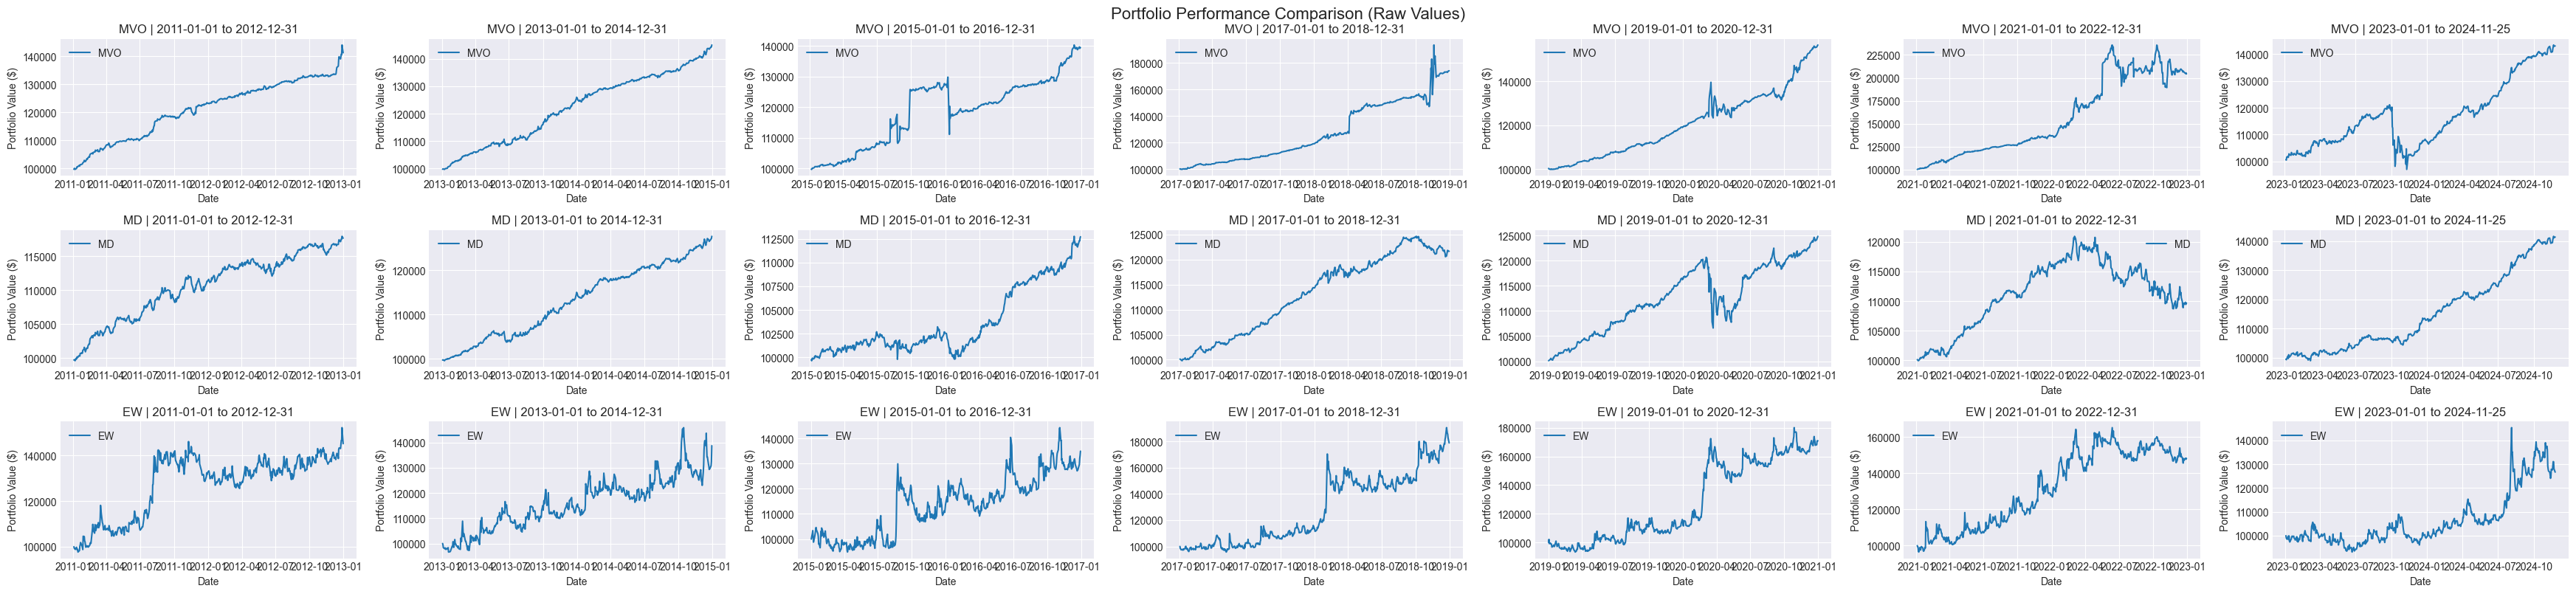

In [15]:
strategies = ['MVO', 'MD', 'EW']
plot_performance_comparison(portfolio_histories, periods, strategies)

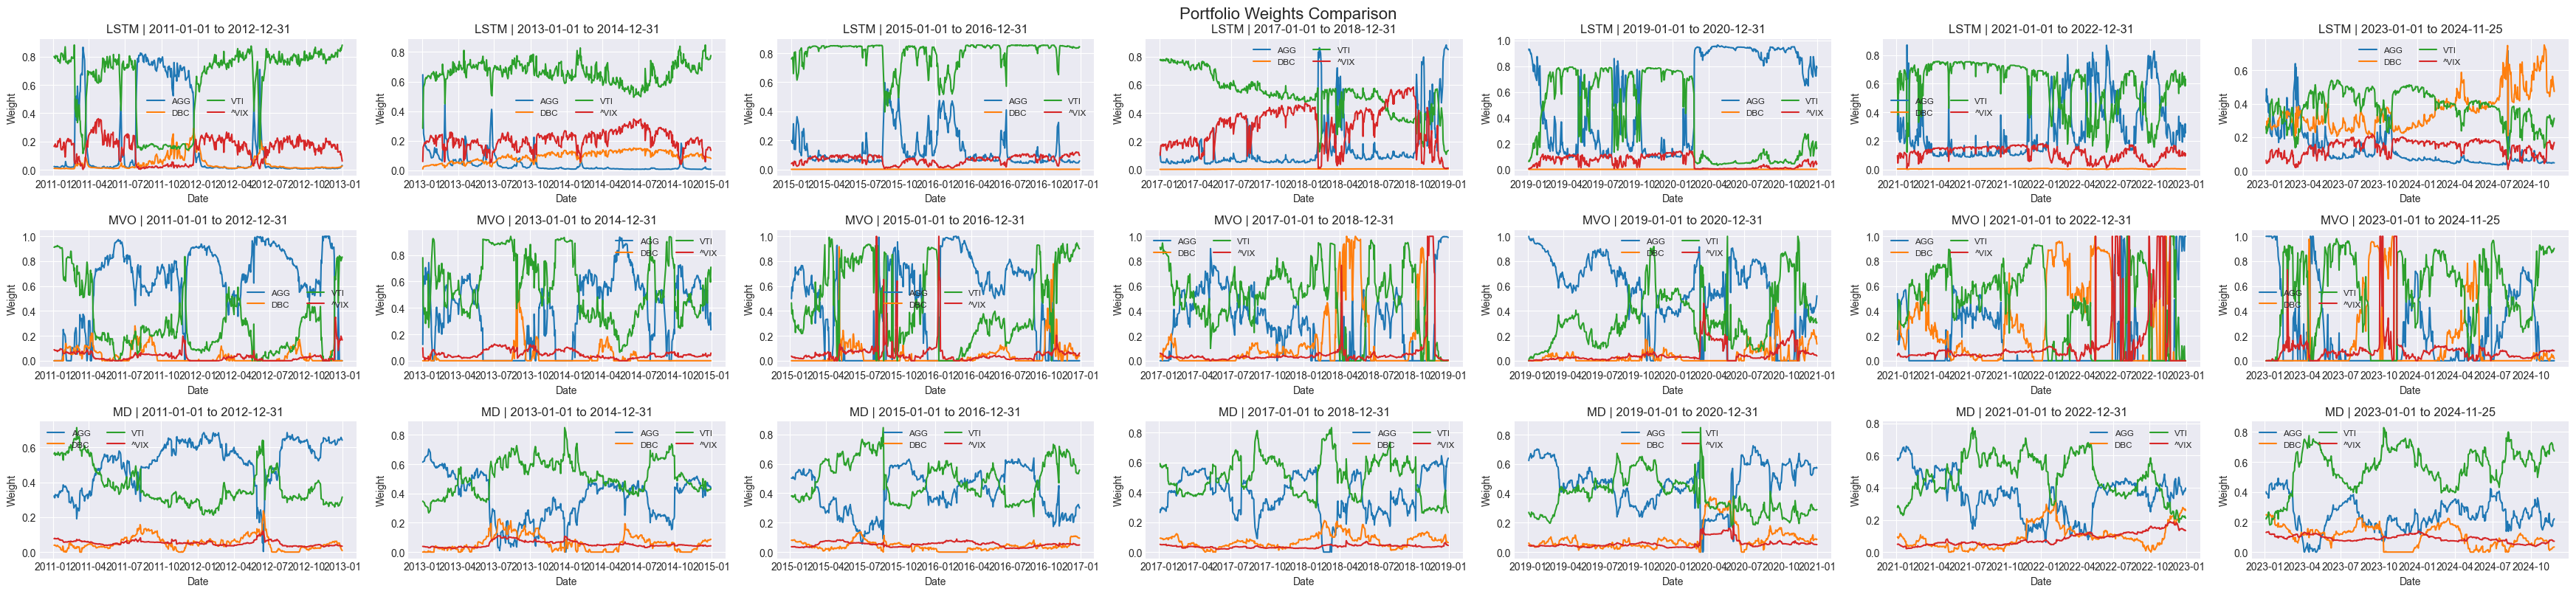

In [17]:
strategies = ['LSTM','MVO', 'MD']
asset_names = TICKERS
plot_weights_comparison(portfolio_histories, periods, strategies, asset_names)